## Transfer Learning for Recognition of Wildlife Camera Trap Imagery (2019)
### By Andrew J. Flighty


### Introduction

This notebook contains the machine learning pipeline for training MobileNet to recognise wildlife camera trap imagery. The model was trained on the Wellington camera traps dataset (available at http://lila.science/datasets/wellingtoncameratraps). 


### Approach

The following workflow is implemented:

1. Import the dataset.
2. Preprocess the data - partition into testing, validation, and test sets.
3. Analyse the provided metadata, and inspect image quality.
4. Import MobileNet, adjust hyperparameters, then train and predict on the dataset.
5. Evaluate model results by examining precision/recall/F1 scores. Also inspect confusion matrix.

In [1]:
# Data manipulation libraries
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True) # To suppress e notation

# Data visualisation libraries 
import matplotlib.pyplot as plt
import seaborn as sns

# Dealing with directories
import os 

In [ ]:
import keras
import tensorflow as tf
from tensorflow.python.client import device_lib

# Set up GPU and CPU environment
config = tf.ConfigProto(device_count = {'GPU': 1, 'CPU': 76} ) 
keras.backend.set_session(tf.Session(config=config))
print(device_lib.list_local_devices())
tf.test.is_gpu_available()

### Data preprocessing

In [ ]:
# Categorize images by name into folders

import shutil

meta = pd.read_csv('Wildlife Recognition/wellington_camera_traps.csv')

for img in os.listdir('D:/wct_images/images'):
    if not meta.index[meta['file'] == img.lower()].tolist():
        continue
    index = meta.index[meta['file'] == img.lower()].tolist().pop()
    class_ = meta['label'][index]
    
    if class_ == 'CAT':
       shutil.copy(os.path.join('D:/wct_images/images',img.lower()), os.path.join('C:/Users/ajfli/Desktop/cat_/',img.lower()))
    if class_ == 'HEDGEHOG':
       shutil.copy(os.path.join('D:/wct_images/images',img.lower()), os.path.join('C:/Users/ajfli/Desktop/hedgehog_/',img.lower()))
    if class_ == 'RABBIT':
       shutil.copy(os.path.join('D:/wct_images/images',img.lower()), os.path.join('C:/Users/ajfli/Desktop/leporidae_/',img.lower()))
    if class_ == 'POSSUM':
       shutil.copy(os.path.join('D:/wct_images/images',img.lower()), os.path.join('C:/Users/ajfli/Desktop/possum_/',img.lower()))
    if class_ == 'MOUSE':
       shutil.copy(os.path.join('D:/wct_images/images',img.lower()), os.path.join('C:/Users/ajfli/Desktop/rodent_/',img.lower()))
    if class_ == 'NOTHINGHERE':
        shutil.copy(os.path.join('D:/wct_images/images',img.lower()), os.path.join('C:/Users/ajfli/Desktop/nothinghere_/',img.lower()))
    if class_ == 'UNCLASSIFIABLE':
        shutil.copy(os.path.join('D:/wct_images/images',img.lower()), os.path.join('C:/Users/ajfli/Desktop/unclassifiable_/',img.lower()))
    

In [ ]:
# Move images to train, valid, and test folders (80%, 10%, 10%)
from random import sample

classes = ['bird','nothinghere','cat','hedgehog','mouse','rabbit','possum','unclassifiable',
                  'ship rat','rat','dog','norway rat','goat','hare','pig','mustelid']

for class_ in classes:
    print(class_)
    imgs = os.listdir(os.path.join('files', class_))
    print(len(imgs))
    break
    
for class_ in classes:
    imgs = os.listdir(os.path.join('other', class_))
    imgs = sample(imgs, len(imgs))
    df = pd.DataFrame(imgs)
    # Split images to train, valid, and test sets
    train, valid, test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.90*len(df))])
    print(class_,':')
    print('Number of images in train set:',len(train))
    print('Number of images in valid set:',len(valid))
    print('Number of images in test set:',len(test), '\n')
    
    # Move to appropriate folders
    for img in train.values:
        shutil.copy(os.path.join('other',class_,img[0]), os.path.join('train',img[0]))
    for img in valid.values:
        shutil.copy(os.path.join('other',class_,img[0]), os.path.join('valid',img[0]))
    for img in test.values:
        shutil.copy(os.path.join('other',class_,img[0]), os.path.join('test',img[0]))

### Examine metadata

In [5]:
meta_data = pd.read_csv('wellington_camera_traps.csv')
print('Number of images:', meta_data.shape[0])
meta_data.head()

Number of images: 270450


sequence image_sequence                      file label  site  \
0         2         image1  290716114012001a1116.jpg  BIRD  001a   
1        12         image1  100816090812001a1111.jpg  BIRD  001a   
2        17         image1  180516121622001a1602.jpg  BIRD  001a   
3        18         image1  260416120224001a1601.jpg  BIRD  001a   
4        20         image1  160516023810001a1606.jpg   CAT  001a   

              date camera  
0  7/29/2016 11:40    111  
1   8/10/2016 9:08    111  
2  5/18/2016 12:16    160  
3  4/26/2016 12:02    160  
4   5/16/2016 2:38    160

In [4]:
CATEGORIES = meta_data['label'].unique()
CATEGORIES = [el.lower() for el in CATEGORIES]
NUM_CATEGORIES = len(CATEGORIES)
print('Number of categories:', NUM_CATEGORIES)

Number of categories: 17


There are 17 categories and a total of 270,450 images. The majority of images are of birds (57.1%).
Two of the categories (NOTHINGHERE, UNCLASSIFIABLE) are not actually animal categories.

Count          %
BIRD            154525  57.136254
NOTHINGHERE      45721  16.905528
CAT              30285  11.198003
HEDGEHOG         10706   3.958588
MOUSE             6481   2.396376
RABBIT            5714   2.112775
POSSUM            4351   1.608800
UNCLASSIFIABLE    3484   1.288223
Ship rat          3183   1.176927
RAT               2757   1.019412
DOG                998   0.369015
Norway rat         861   0.318358
GOAT               645   0.238491
DEER               312   0.115363
HARE               207   0.076539
PIG                193   0.071363
MUSTELID            27   0.009983

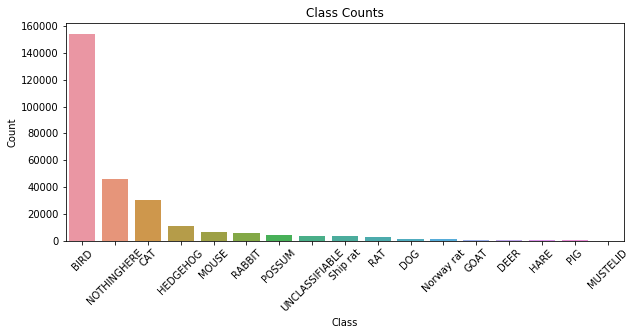

In [58]:
# Plot distribution of classes
plt.figure(figsize=(10, 4));
sns.countplot(x='label', data=meta_data, order = meta_data['label'].value_counts().index);
plt.title('Class Counts');
plt.ylabel('Count');
plt.xlabel('Class');
plt.xticks(rotation=45);

df_percentage = pd.DataFrame(meta_data['label'].value_counts())
df_percentage['%'] = df_percentage['label']/meta_data.shape[0]*100
df_percentage.rename(columns={'label':'Count'})

The class distributions are not even; they vary from a max of 154,525 images to a min of 27 images. 
Classes will need to be balanced in order to get the best results. One option is to consider the weight contribution of each instance to loss function when training the CNN.

### Sample example images

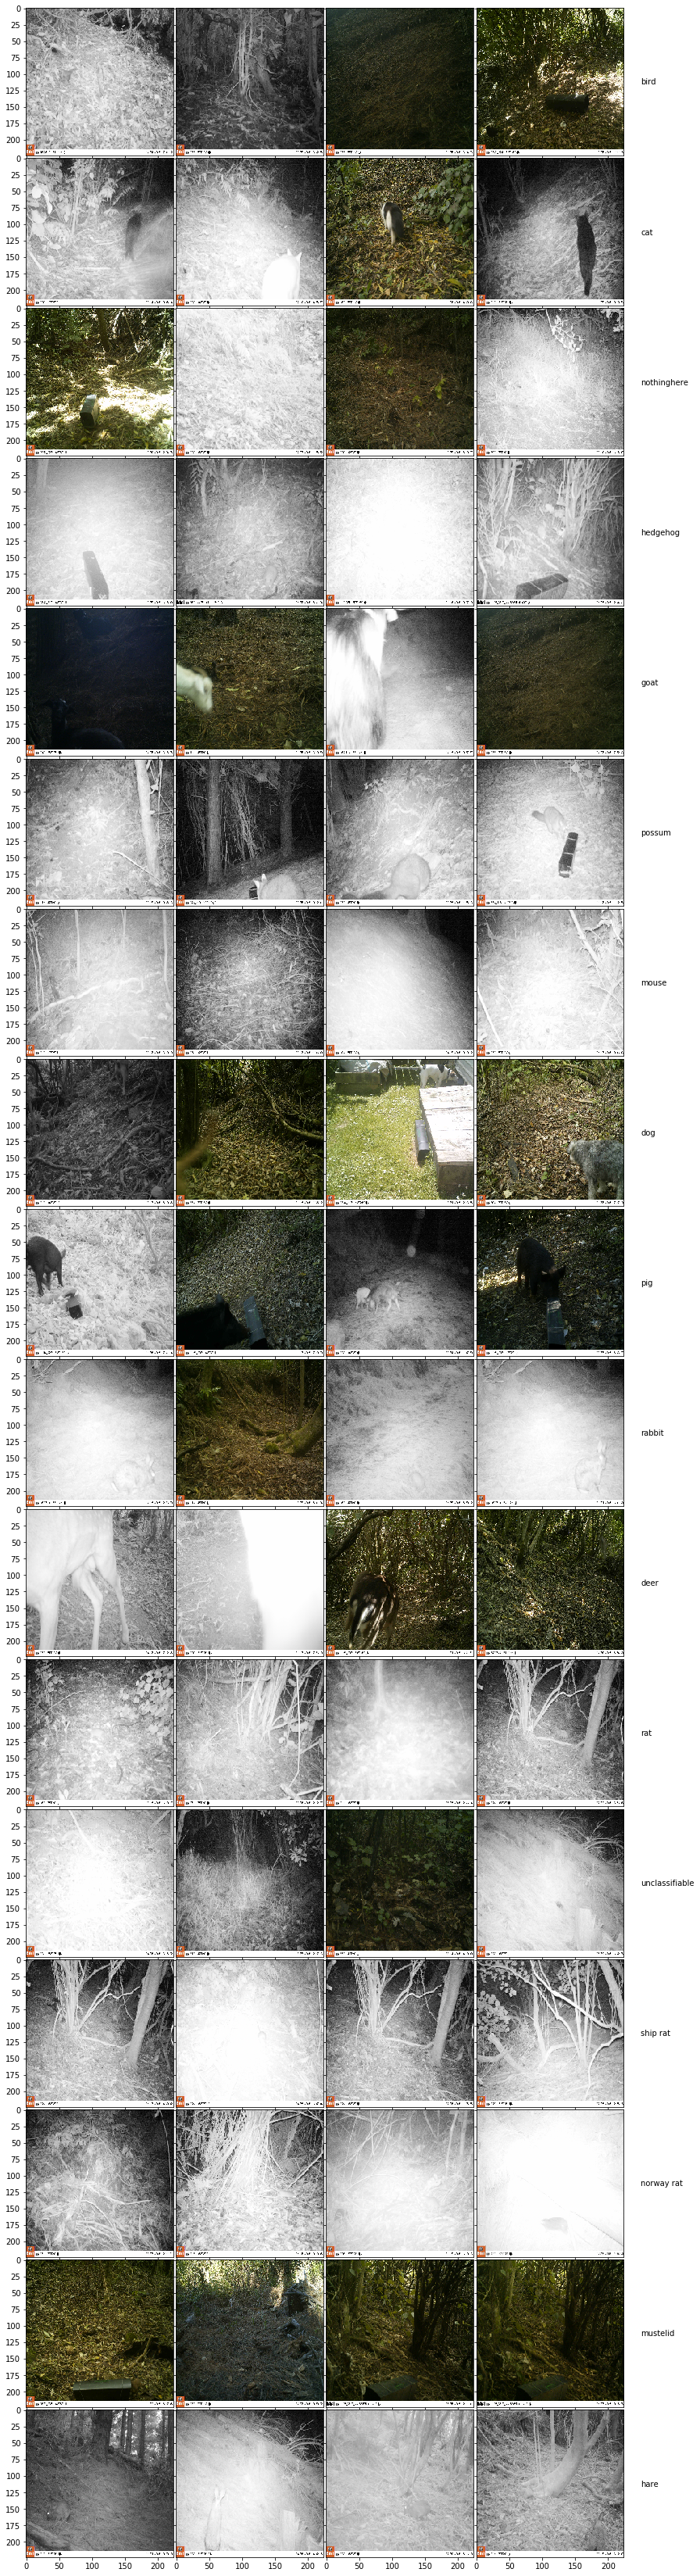

In [78]:
from random import sample 
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid

def read_img(filepath):
    img = image.load_img(filepath, target_size=(224,224))
    img = image.img_to_array(img)
    return img

def sample_images():
    fig = plt.figure(1, figsize=(50, 60))
    grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, 4), axes_pad=0.05)
    i = 0
    for category_id, category in enumerate(CATEGORIES):
        # Get all images for each category
        imgs = os.listdir(os.path.join(DATADIR,'wct_images_categories',category))
        # Randomly select only 4
        imgs = sample(imgs, 4)
        # Plot each image to the grid
        for img in imgs:
            img = read_img(os.path.join(DATADIR,'wct_images_categories',category,img))
            ax = grid[i]
            ax.imshow(img / 255.)
            ax.text(250, 112, category, verticalalignment='center')
            i += 1
    plt.show();
    
#sample_images()

### Image preparation

In [40]:
train_path = 'train'
valid_path = 'valid'
test_path = 'test'

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input

BATCH_SIZE = 32

train_batches = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   ).flow_from_directory(train_path,
                                                                    target_size=(224,224),
                                                                    batch_size=BATCH_SIZE,
                                                                    class_mode='categorical')

valid_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(valid_path,
                                                                                                target_size=(224,224),
                                                                                                batch_size=BATCH_SIZE,
                                                                                                class_mode='categorical')

test_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(test_path,
                                                                                               target_size=(224,224),
                                                                                               batch_size=BATCH_SIZE,
                                                                                               class_mode='categorical',
                                                                                               shuffle=False)

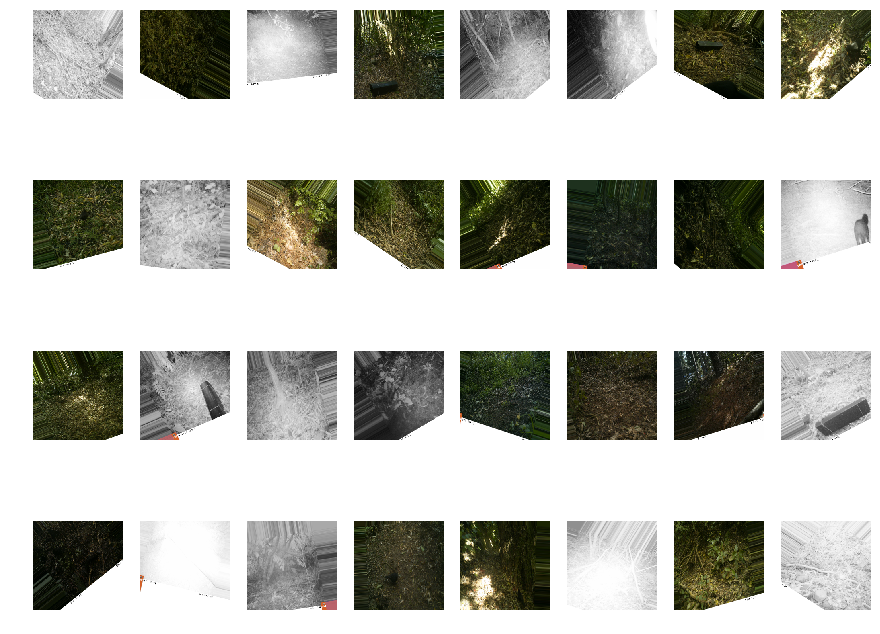

In [54]:
# Plot some images resulting from data augmentation strategies
x_batch, y_batch = next(train_batches)
plt.figure(figsize=(15, 12))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

### Import and re-train MobileNet

In [ ]:
from keras.preprocessing import image
from keras.applications import MobileNet
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D
from keras.layers.core import Dense, Activation
from keras import optimizers
from keras.models import Model

# Enabling of class weights to address class imbalances
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_batches.classes), 
                train_batches.classes)
class_weights

In [ ]:
# Import MobileNet
base_model = MobileNet(weights='imagenet',
                       include_top=False,
                       input_shape=(224, 224, 3))

# Modify final layer to match our number of classes
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(8, activation='softmax')(x) # final layer with softmax activation
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers
for layer in model.layers:
    layer.trainable=False
# Unfreeze the first X layers so that they are trainable
for layer in model.layers[:3]:
    layer.trainable=False
for layer in model.layers[3:]:
    layer.trainable=True

EPOCHS = 1000
LEARNING_RATE = .0001
OPTIMIZER = optimizers.SGD(lr=LEARNING_RATE, decay=LEARNING_RATE/EPOCHS) # Other options: RMSprop, ADAM, Adagrad

model.compile(optimizer=OPTIMIZER,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# # Examine layers
# for i,layer in enumerate(model.layers):
#     print(i,layer.name)

### Fit the model

In [1]:
STEP_SIZE_TRAIN = train_batches.n//train_batches.batch_size
STEP_SIZE_VALID = valid_batches.n//valid_batches.batch_size
STEP_SIZE_TEST = test_batches.n//test_batches.batch_size

# Fit model
history = model.fit_generator(train_batches, steps_per_epoch=STEP_SIZE_TRAIN,
                             validation_data=valid_batches, validation_steps=STEP_SIZE_VALID, epochs=EPOCHS,
                             class_weight=class_weights,
                             use_multiprocessing=True,
                             workers=76
                             )
test_batches.reset()

### Predict on test set

In [ ]:
predictions = model.predict_generator(test_batches, steps=STEP_SIZE_TEST, verbose=1)

### Evaluate model results


In [ ]:
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_cm(actual, predicted, plot_labels, normalize=False):
    cm = confusion_matrix(predictions.argmax(axis=1), test_labels)
    if normalize == True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(1, figsize=(16,7))
    ax = sns.heatmap(cm, ax=ax, cmap=plt.cm.Greens, annot=True, fmt='g', annot_kws={"size": 14})
    ax.set_xticklabels(plot_labels)
    ax.set_yticklabels(plot_labels)
    ax.set_ylim(len(plot_labels)+0.5, -0.5)
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted class')
    plt.xlabel('Actual class')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
                 rotation_mode="anchor")
    plt.show();

In [ ]:
# Get vector of true animal classes
test_labels = test_batches.classes[:len(predictions)] # Only take images up to a certain point (due to batch size leftover)
print('\nNumber of test images:', test_labels.shape[0])

# Plot confusion matrix
cm_plot_labels = ['bird','cat','hedgehog','leporidae','nothinghere_unclassifiable','other','possum','rodent']
plot_cm(test_labels, predictions, cm_plot_labels, normalize=False)
# Get and save advanced evaluation metrics
from pycm import *
cm = ConfusionMatrix(actual_vector=test_labels, predict_vector=predictions.argmax(axis=1)) 
cm.save_obj('my_models/transfer_class8_n1000__b32_last3_augment_SGD0001_epoch1000_decay', save_stat=True)
print('Overall accuracy on test set:', round(cm.overall_stat['Overall ACC'],4))

# Get class frequencies in test set
unique_elements, counts_elements = np.unique(test_labels, return_counts=True)
print('\nClass frequencies:\n')
for i, class_ in enumerate(cm_plot_labels):
    print(class_,':',counts_elements[i])
    
# Get class F1 scores
print('\nClass F1 scores:\n')
f1_scores = []
for i, class_ in enumerate(cm_plot_labels):
    f1_score = round(cm.class_stat['F1'][str(i)],4)
    #cm.class_stat['PPV'] # for precision
    #cm.class_stat['TPR'] # for recall
    print(class_,':', f1_score)
    f1_scores.append(f1_score)
# Get class f1 scores that are easy to copy-paste into Model Diary
print('\n')
for f1_score in f1_scores:
    print(f1_score, end='\t')
    
# For loading a saved confusion matrix object
#cm_load = ConfusionMatrix(file=open('transfer_last3.obj', 'r'))
# report = classification_report(predictions.argmax(axis=1), test_labels[:40576], target_names=cm_plot_labels, output_dict=True)
# df = pd.DataFrame(report).transpose()
# df.to_csv('my_models/transfer_last3_classreport.csv')

In [ ]:
# Plot training and validation accuracy as a function of epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Predict on an image of choice
def load_image(img_path, show=False):
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show() 
    return img_tensor

img_path = os.path.join(DATADIR,'wct_images/valid/bird/010216171940045c5173.jpg')
new_image = load_image(img_path, show=True)

pred = model.predict(new_image)
pred = pred.argmax(axis=1)

predicted_class = list(test_batches.class_indices.keys())[list(test_batches.class_indices.values()).index(pred)]
print(f'Predicted class: {predicted_class}')

### Save the model

In [ ]:
# Save model architecture and weights (.h5 file)
model.save('my_models/transfer_class8_n1000__b32_last3_augment_SGD0001_epoch1000_decay.h5')

# Save as JSON (for web applications)
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,'transfer_class8_n1000__b32_last3_augment_SGD0001_epoch1000_decay_web')